# Module Installation

In [ ]:
!pip install nltk

In [ ]:
!pip install imbalanced-learn

In [ ]:
!pip install transformers

In [ ]:
!pip install tensorflow-hub

# Data Collection (MIMIC-III)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
note = pd.read_csv ('/content/drive/MyDrive/bq-results-20240403-140857-1712153424464/bq-results-20240403-140857-1712153424464.csv')
print(note)

       ROW_ID  SUBJECT_ID  HADM_ID           CATEGORY  \
0       34077       28958   190721  Discharge summary   
1        7725       97310   112338  Discharge summary   
2       54499       11328   106437  Discharge summary   
3        9664       54721   139628  Discharge summary   
4       17670       20014   142842  Discharge summary   
...       ...         ...      ...                ...   
59647   57178        3683   109908  Discharge summary   
59648   56496        1335   105480  Discharge summary   
59649   56915       24317   166035  Discharge summary   
59650   56666       15815   164998  Discharge summary   
59651   58884       28712   162069  Discharge summary   

                                                    TEXT  
0      Admission Date:  [**2103-6-22**]              ...  
1      Admission Date:  [**2184-3-27**]              ...  
2      Admission Date:  [**2165-3-30**]       Dischar...  
3      Admission Date:  [**2136-6-11**]              ...  
4      Admission Dat

In [ ]:
# Read DIAGNOSES_ICD.csv
diagnoses_df = pd.read_csv('DIAGNOSES_ICD.csv')
print(diagnoses_df)

        ROW_ID  SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE
0         1297         109   172335      1.0     40301
1         1298         109   172335      2.0       486
2         1299         109   172335      3.0     58281
3         1300         109   172335      4.0      5855
4         1301         109   172335      5.0      4254
...        ...         ...      ...      ...       ...
651042  639798       97503   188195      2.0     20280
651043  639799       97503   188195      3.0     V5869
651044  639800       97503   188195      4.0     V1279
651045  639801       97503   188195      5.0      5275
651046  639802       97503   188195      6.0      5569

[651047 rows x 5 columns]


# Pre-Processing



*   Stopword Removal
*   Newline removal
*   Punctuation Removal


In [ ]:

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pandas as pd
import re
import numpy as np
import pandas as pd
import torch
from nltk.tokenize import word_tokenize, sent_tokenize
from keras.preprocessing.sequence import pad_sequences


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]

    return ' '.join(filtered_text)

def lemmatization(text):
    """
    Preprocess the text by tokenizing, lemmatizing, and removing short words.

    Parameters:
    text (str): The input text to be preprocessed.

    Returns:
    str: The preprocessed text.
    """
    # Tokenize the text into words
    words = word_tokenize(text)

    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Lemmatize words and remove short words
    processed_words = [lemmatizer.lemmatize(word) for word in words]

    # Join the processed words back into a string
    processed_text = ' '.join(processed_words)

    return processed_text


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#Removes leading and trailing whitespace, including newline characters, from the given text.
def remove_newline(text):
  text = text.strip()
  return text


In [ ]:
#To remove numbers from a string
def remove_numbers(text):
    return re.sub(r'\d+', '', text)


In [ ]:
import string

def remove_punctuation(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove digits
    text = ''.join([w for w in text if not w.isdigit()])

    # Define regular expression patterns for further cleaning
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    #BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

    # Convert text to lowercase
    text = text.lower()

    # Replace symbols defined in REPLACE_BY_SPACE_RE with space
    text = REPLACE_BY_SPACE_RE.sub('', text)

    return text


def convert_to_lower(text):
    """
    Convert text to lowercase.

    Args:
        text (str): Input text to be converted.

    Returns:
        str: Lowercase version of the input text.
    """
    return text.lower()

def remove_whitespace(text):
    """
    Remove all leading and trailing whitespace characters from the text
    and collapse multiple consecutive whitespace characters into a single space.

    Parameters:
    text (str): The input text containing whitespace characters.

    Returns:
    str: The text with whitespace characters removed.
    """
    # Remove leading and trailing whitespace
    clean_text = text.strip()

    # Remove all whitespace characters
    clean_text = ' '.join(filter(None, text.split()))

    return clean_text

def remove_less_than_theshold_words(text, threshold=3):
    '''
    Removes less than threshold characters from string, if present

    Step 1: Use word_tokenize() to get tokens from string
    Step 2: Removes words whose length falls below the threshold (by default = 1)

    Args:
        text (str): String to which the functions are to be applied, string

    Returns:
        String with removed words whose length was below the threshold (by default = 1)
    '''
    threshold = threshold

    words = word_tokenize(text)
    text = ' '.join([word for word in words if len(word) > threshold])
    return text

In [ ]:
diagnoses_df.isnull().sum()

diagnoses_df = diagnoses_df.dropna(subset = ['ICD9_CODE', 'SEQ_NUM'])

Additional Pre-Processing

*   Append ICD-9 code to dataframe

In [ ]:
TOP_10_ICD_CODE = 10
# Step 1: Count the frequency of each ICD-9 code
icd9_counts = diagnoses_df['ICD9_CODE'].value_counts()

# Step 2: Select the top 10 common ICD-9 codes
top_10_icd9 = icd9_counts.head(TOP_10_ICD_CODE)

# Step 3: Filter diagnoses_df to keep only the top 10 common ICD-9 codes
filtered_diagnoses_df = diagnoses_df[diagnoses_df['ICD9_CODE'].isin(top_10_icd9.index)]

# Group filtered_diagnoses_df by 'HADM_ID' and aggregate the ICD-9 codes into a list
grouped_diagnoses = filtered_diagnoses_df.groupby('HADM_ID')['ICD9_CODE'].agg(list).reset_index()

# Step 4: Merge grouped_diagnoses with mimic_df based on HADM_ID
merged_df = pd.merge(note, grouped_diagnoses, on='HADM_ID', how='left')

# Display the first 10 rows of the merged DataFrame
print(merged_df.head(10))



   ROW_ID  SUBJECT_ID  HADM_ID           CATEGORY  \
0   34077       28958   190721  Discharge summary   
1    7725       97310   112338  Discharge summary   
2   54499       11328   106437  Discharge summary   
3    9664       54721   139628  Discharge summary   
4   17670       20014   142842  Discharge summary   
5   50542        9584   105048  Discharge summary   
6    5463       25012   126266  Discharge summary   
7   13562       14025   106077  Discharge summary   
8   41330       57738   161448  Discharge summary   
9   19617       16574   145391  Discharge summary   

                                                TEXT  \
0  Admission Date:  [**2103-6-22**]              ...   
1  Admission Date:  [**2184-3-27**]              ...   
2  Admission Date:  [**2165-3-30**]       Dischar...   
3  Admission Date:  [**2136-6-11**]              ...   
4  Admission Date:  [**2153-4-17**]       Dischar...   
5  Admission Date:  [**2178-5-8**]     Discharge ...   
6  Admission Date:  [**2

Removing sentences that only have a few sentences (causing error where each row would be inconsistent [when already converted to tensor form])

In [ ]:

# Define a function to count the number of sentences in a text
def count_sentences(text):
    # Split the text into sentences based on a delimiter (e.g., '.')
    sentences = text.split('.')
    # Remove empty strings from the list
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    # Return the number of sentences
    return len(sentences)

# Define the minimum number of sentences required
min_sentences = 100  # Adjust this value as needed

# Apply the count_sentences function to the 'TEXT' column and create a new column with the counts
merged_df['sentence_count'] = merged_df['TEXT'].apply(count_sentences)

# Filter out rows where the sentence count is less than the minimum required
merged_df = merged_df[merged_df['sentence_count'] >= min_sentences]

merged_df = merged_df.drop(columns=['sentence_count'])


In [ ]:
#Handling of dataframe data type
merged_df.convert_dtypes().dtypes

ROW_ID                 Int64
SUBJECT_ID             Int64
HADM_ID                Int64
CATEGORY      string[python]
TEXT          string[python]
ICD9_CODE             object
dtype: object

Removal of null values in merged_df

In [ ]:
print(merged_df.isnull().sum())
merged_df = merged_df.dropna(subset = ['ICD9_CODE'])
print(merged_df.isnull().sum())

ROW_ID           0
SUBJECT_ID       0
HADM_ID          0
CATEGORY         0
TEXT             0
ICD9_CODE     6945
dtype: int64
ROW_ID        0
SUBJECT_ID    0
HADM_ID       0
CATEGORY      0
TEXT          0
ICD9_CODE     0
dtype: int64


In [ ]:
merged_df

,ROW_ID,SUBJECT_ID,HADM_ID,CATEGORY,TEXT,ICD9_CODE
0,34077,28958,190721,Discharge summary,Admission Date: [**2103-6-22**] ...,[41401]
5,50542,9584,105048,Discharge summary,Admission Date: [**2178-5-8**] Discharge ...,"[4280, 25000]"
6,5463,25012,126266,Discharge summary,Admission Date: [**2135-7-3**] D...,"[5990, 42731, 4280, 41401]"
8,41330,57738,161448,Discharge summary,Admission Date: [**2162-2-25**] ...,[2724]
10,38326,58631,182422,Discharge summary,Admission Date: [**2176-5-23**] ...,"[51881, 5849, 41401, 42731, 4019]"
...,...,...,...,...,...,...
59618,56680,17145,105119,Discharge summary,"Name: [**Known lastname **], [**Known firstna...","[4280, 5849, 42731]"
59620,58474,87056,177419,Discharge summary,"Name: [**Known lastname 14318**],[**Known fir...","[5990, 4019]"
59633,57238,20043,121043,Discharge summary,"Name: [**Known lastname 10565**],[**Known fir...","[5849, 5990, 4280]"
59639,55771,5071,120208,Discharge summary,"Name: [**Known lastname 4298**],[**Known firs...","[5849, 4280, 42731, 2724]"


In [ ]:
merged_df = merged_df.iloc[:5000]

In [ ]:
#merged_df['TEXT'] = merged_df['TEXT'].apply(lemmatization)
merged_df['TEXT'] = merged_df['TEXT'].apply(remove_stopwords)
merged_df['TEXT'] = merged_df['TEXT'].apply(remove_newline)
merged_df['TEXT'] = merged_df['TEXT'].apply(remove_numbers)
merged_df['TEXT'] = merged_df['TEXT'].apply(remove_punctuation)
merged_df['TEXT'] = merged_df['TEXT'].apply(convert_to_lower)
merged_df['TEXT'] = merged_df['TEXT'].apply(remove_whitespace)
merged_df['TEXT'] = merged_df['TEXT'].apply(remove_less_than_theshold_words)

<ipython-input-20-8f8ac5a6f242>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['TEXT'] = merged_df['TEXT'].apply(remove_stopwords)
<ipython-input-20-8f8ac5a6f242>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['TEXT'] = merged_df['TEXT'].apply(remove_newline)
<ipython-input-20-8f8ac5a6f242>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

In [ ]:
top_10_icd9


ICD9_CODE
4019     20703
4280     13111
42731    12891
41401    12429
5849      9119
25000     9058
2724      8690
51881     7497
5990      6555
53081     6326
Name: count, dtype: int64

In [ ]:
#Based on Iloc (specified sample size)
exploded_df = merged_df.explode('ICD9_CODE')

# Count the frequency of each unique ICD-9 code
icd9_code_counts = exploded_df['ICD9_CODE'].value_counts()

print(icd9_code_counts)


ICD9_CODE
4019     2341
4280     1745
42731    1643
41401    1522
5849     1226
25000    1062
2724     1057
51881     888
5990      865
53081     780
Name: count, dtype: int64


In [ ]:
merged_df

,ROW_ID,SUBJECT_ID,HADM_ID,CATEGORY,TEXT,ICD9_CODE
0,34077,28958,190721,Discharge summary,admission date discharge date service medicine...,[41401]
5,50542,9584,105048,Discharge summary,admission date discharge date date birth servi...,"[4280, 25000]"
6,5463,25012,126266,Discharge summary,admission date discharge date service medicine...,"[5990, 42731, 4280, 41401]"
8,41330,57738,161448,Discharge summary,admission date discharge date date birth servi...,[2724]
10,38326,58631,182422,Discharge summary,admission date discharge date date birth servi...,"[51881, 5849, 41401, 42731, 4019]"
...,...,...,...,...,...,...
8680,28330,19622,148517,Discharge summary,admission date discharge date date birth servi...,[5990]
8682,53537,68780,118453,Discharge summary,admission date discharge date date birth servi...,"[4280, 25000, 2724, 41401]"
8683,10719,2251,156816,Discharge summary,admission date discharge date date birth servi...,"[4019, 53081]"
8685,35499,51859,118646,Discharge summary,admission date discharge date date birth servi...,"[4280, 42731, 25000]"


In [ ]:
# Initialize a list of top 10 codes
#top_10_icd9 = list(top_10_icd9.keys())

# # Create a code_dict where the code is the key and the index is the value
# code_dict = {code: index for index, code in enumerate(top_10_icd9)}

# row_list = []
# for _, row in merged_df.iterrows():
#     # Initialize an empty list to hold the encoded values
#     temp_dict = []

#     # Initialize the temp_dict with zeros
#     for _ in range(10):
#         temp_dict.append(0)

#     for code in row['ICD9_CODE']:
#         # Check if the code is in the code_dict
#         if code in code_dict:
#             # Get the index from the code_dict
#             index = code_dict[code]
#             # Update the corresponding value in temp_dict
#             temp_dict[index] = 1

#     row_list.append(temp_dict)

# # Assign the row_list as the 'encoded_values' column in the DataFrame
# merged_df['encoded_values'] = row_list



#Testing : One Hot Encode
import pandas as pd
import numpy as np

def one_hot_encoding(df):
    # Create an empty DataFrame to store the one-hot encoded values
    dummy_df = pd.DataFrame()

    # Iterate through each ICD-9 code in the top 50 codes
    for code, _ in icd9_code_counts.items():
        # Create a new column in the dummy DataFrame with the current code
        dummy_df[code] = df['ICD9_CODE'].apply(lambda x: 1 if code in x else 0)

    # Concatenate the dummy DataFrame with the original DataFrame
    merged_df = pd.concat([df, dummy_df], axis=1)
    return merged_df

merged_df = one_hot_encoding(merged_df)
merged_df

,ROW_ID,SUBJECT_ID,HADM_ID,CATEGORY,TEXT,ICD9_CODE,4019,4280,42731,41401,5849,25000,2724,51881,5990,53081
0,34077,28958,190721,Discharge summary,admission date discharge date service medicine...,[41401],0,0,0,1,0,0,0,0,0,0
5,50542,9584,105048,Discharge summary,admission date discharge date date birth servi...,"[4280, 25000]",0,1,0,0,0,1,0,0,0,0
6,5463,25012,126266,Discharge summary,admission date discharge date service medicine...,"[5990, 42731, 4280, 41401]",0,1,1,1,0,0,0,0,1,0
8,41330,57738,161448,Discharge summary,admission date discharge date date birth servi...,[2724],0,0,0,0,0,0,1,0,0,0
10,38326,58631,182422,Discharge summary,admission date discharge date date birth servi...,"[51881, 5849, 41401, 42731, 4019]",1,0,1,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8680,28330,19622,148517,Discharge summary,admission date discharge date date birth servi...,[5990],0,0,0,0,0,0,0,0,1,0
8682,53537,68780,118453,Discharge summary,admission date discharge date date birth servi...,"[4280, 25000, 2724, 41401]",0,1,0,1,0,1,1,0,0,0
8683,10719,2251,156816,Discharge summary,admission date discharge date date birth servi...,"[4019, 53081]",1,0,0,0,0,0,0,0,0,1
8685,35499,51859,118646,Discharge summary,admission date discharge date date birth servi...,"[4280, 42731, 25000]",0,1,1,0,0,1,0,0,0,0


In [ ]:
exploded_df = merged_df.explode('ICD9_CODE')

# Count the frequency of each unique ICD-9 code
icd9_code_counts = exploded_df['ICD9_CODE'].value_counts()

print(icd9_code_counts)


ICD9_CODE
4019     2341
4280     1745
42731    1643
41401    1522
5849     1226
25000    1062
2724     1057
51881     888
5990      865
53081     780
Name: count, dtype: int64


In [ ]:
icd9_code_list = list(icd9_code_counts.keys())


Mean token length: 952.7344


<ipython-input-27-7c62b17bb134>:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tokenized_words)


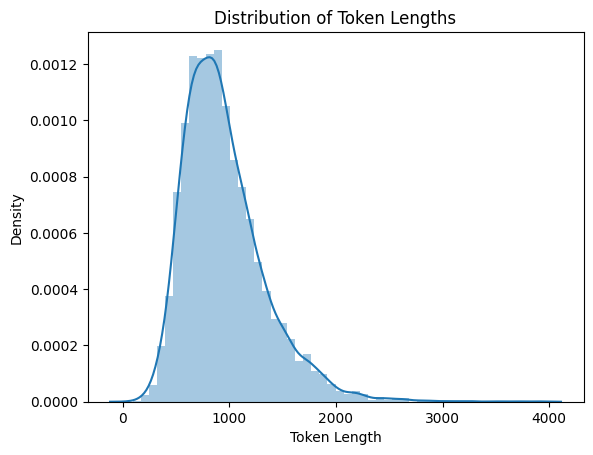

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
tokenized_words = []

# Iterate over rows in the DataFrame
for _, row in merged_df.iterrows():
    # Tokenize each sentence in the current row into words
    words = []
    for sentence in sent_tokenize(row["TEXT"]):
        # Tokenize the sentence into words and limit the number of words to TOKEN_LIMIT
        words.extend(word_tokenize(sentence.lower()))
        tokenized_words.append(len(words))

# Calculate the mean of token lengths
mean_token_length = np.mean(tokenized_words)
print("Mean token length:", mean_token_length)

# Plot the distribution of token lengths
sns.distplot(tokenized_words)
plt.title('Distribution of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Density')
plt.show()

In [ ]:
merged_df

,ROW_ID,SUBJECT_ID,HADM_ID,CATEGORY,TEXT,ICD9_CODE,4019,4280,42731,41401,5849,25000,2724,51881,5990,53081
0,34077,28958,190721,Discharge summary,admission date discharge date service medicine...,[41401],0,0,0,1,0,0,0,0,0,0
5,50542,9584,105048,Discharge summary,admission date discharge date date birth servi...,"[4280, 25000]",0,1,0,0,0,1,0,0,0,0
6,5463,25012,126266,Discharge summary,admission date discharge date service medicine...,"[5990, 42731, 4280, 41401]",0,1,1,1,0,0,0,0,1,0
8,41330,57738,161448,Discharge summary,admission date discharge date date birth servi...,[2724],0,0,0,0,0,0,1,0,0,0
10,38326,58631,182422,Discharge summary,admission date discharge date date birth servi...,"[51881, 5849, 41401, 42731, 4019]",1,0,1,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8680,28330,19622,148517,Discharge summary,admission date discharge date date birth servi...,[5990],0,0,0,0,0,0,0,0,1,0
8682,53537,68780,118453,Discharge summary,admission date discharge date date birth servi...,"[4280, 25000, 2724, 41401]",0,1,0,1,0,1,1,0,0,0
8683,10719,2251,156816,Discharge summary,admission date discharge date date birth servi...,"[4019, 53081]",1,0,0,0,0,0,0,0,0,1
8685,35499,51859,118646,Discharge summary,admission date discharge date date birth servi...,"[4280, 42731, 25000]",0,1,1,0,0,1,0,0,0,0


# Input Layer

In [ ]:
# importing libraries
import random
import torch
from transformers import BertTokenizer, BertModel

**BioWordVec Embedding (First Word Emebdding)**

In [ ]:
filename = "/content/drive/MyDrive/BioWordVec_PubMed_MIMICIII_d200.vec.bin"
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format(filename, binary=True)

Formatting Input
*   special tokens to mark the beginning ([CLS]) and separation/end of sentences ([SEP])
*  BERT Tokenizer is used to convert the input from a string into a list of integer Token IDs, where each ID directly maps to a word or part of a word in the original string.



In [ ]:
# Hyperparameter
TOKEN_LIMIT = 941

def tokenize_sentence(df, text_column):
    """
    Tokenizes sentences in all of the text column of a DataFrame.

    Args:
    - df: DataFrame containing text data.
    - text_column: Name of the column containing text data.

    Returns:
    - DataFrame with an additional column 'tokenized_words' containing tokenized words.
    """
    tokenized_words = []

    # Iterate over rows in the DataFrame
    for _, row in df.iterrows():
        # Tokenize each sentence in the current row into words
        words = []
        for sentence in sent_tokenize(row[text_column]):
            # Tokenize the sentence into words and limit the number of words to TOKEN_LIMIT
            words.extend(word_tokenize(sentence.lower())[:TOKEN_LIMIT])
        tokenized_words.append(words)

    # Add the tokenized words as a new column in the DataFrame
    df['tokenized_words'] = tokenized_words

    return df

def sentence_vector(df, text_column):
    """
    Converts tokenized words in a DataFrame column into sentence vectors using a pre-trained model.

    Args:
    - df: DataFrame containing tokenized words.
    - text_column: Name of the column containing tokenized words.

    Returns:
    - DataFrame with an additional column 'vectors' containing sentence vectors.
    - Torch tensor of sentence vectors.
    """
    # Initialize a list to store sentence vectors for each row
    sentence_vectors_list = []

    # Iterate over rows in the DataFrame
    for _, row in df.iterrows():
        # Initialize a list to accumulate word vectors for each sentence
        sentence_vector = []

        # Iterate over each word in the tokenized sentence
        for word in row[text_column]:
            # Check if the word is present in the model's vocabulary
            if word in model:
                # Add the word vector to the sentence vector
                sentence_vector.append(model[word])
            else:
                # If word is not found, you can add a zero vector or continue
                sentence_vector.append(np.zeros(model.vector_size))

        # Pad the tokenized words to ensure a maximum of TOKEN_LIMIT words per sentence
        if len(sentence_vector) < TOKEN_LIMIT:
            sentence_vector += [np.zeros(model.vector_size)] * (TOKEN_LIMIT - len(sentence_vector))

        # Trim the sentence_vector if it exceeds TOKEN_LIMIT
        sentence_vector = sentence_vector[:TOKEN_LIMIT]

        # Append the sentence vector to the list of sentence vectors for the current row
        sentence_vectors_list.append(sentence_vector)

    # Add the list of sentence vectors as a new column 'vectors' in the DataFrame
    df['vectors'] = sentence_vectors_list
    sentence_vectors_tensor = torch.tensor(np.array(sentence_vectors_list), dtype=torch.float32)

    return df, sentence_vectors_tensor


In [ ]:
def check_shapes_consistency(df):
    # Iterate through each row in the DataFrame
    for index, row in df.iterrows():
        # Get the shapes of input_ids and attention_masks for the current row
        input_ids_shape = row['input_ids'].shape
        attention_masks_shape = row['attention_masks'].shape

        # Check if the shapes are consistent (e.g., same number of sentences)
        if input_ids_shape[0] != attention_masks_shape[0]:
            # Print the shapes and an error message
            print(f"For row {index}:")
            print("Error: Inconsistent shapes between input_ids and attention_masks")
            print(f"Shape of input_ids: {input_ids_shape}")
            print(f"Shape of attention_masks: {attention_masks_shape}")


**BERT Word Embedding (Second Word Embedding)**


In [ ]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_Discharge_Summary_BERT")
model2 = AutoModel.from_pretrained("emilyalsentzer/Bio_Discharge_Summary_BERT")


def word_embedding_tokenization(df, tokenizer):
    # Initialize lists to store input IDs and attention masks
    input_ids = []
    attention_masks = []

    # For each sentence in the 'TEXT' column...
    for sentence in df["TEXT"]:
        # Tokenize and encode the sentence
        encoded_dict = tokenizer.encode_plus(
                            sentence,
                            add_special_tokens=True,   # Add '[CLS]' and '[SEP]'
                            padding=True,              # Pad sentences
                            truncation=True,           # Truncate sentences
                            max_length=128,            # Adjust sentence length
                            return_attention_mask=True,# Generate attention masks
                            return_tensors='pt',       # Return PyTorch tensors
                       )

        # Append the input IDs and attention mask to the respective lists
        input_ids.append(encoded_dict['input_ids'].unsqueeze(0))
        attention_masks.append(encoded_dict['attention_mask'].unsqueeze(0))

    # Add the input IDs and attention masks as new columns to the DataFrame
    df['input_ids'] = input_ids
    df['attention_masks'] = attention_masks

    print(df['input_ids'].iloc[0].shape)
    print(df['attention_masks'].iloc[0].shape)

    return df

import torch

def generate_embeddings(df,model):
    """
    Generate embeddings using the provided BERT model for each sentence in the DataFrame.

    Args:
    model (torch.nn.Module): Pre-trained BERT model for generating embeddings.
    df (pandas.DataFrame): DataFrame containing input_ids and attention_masks for each sentence.

    Returns:
    torch.Tensor: Tensor containing embeddings for all sentences.
    """
    # Put the model in "evaluation" mode
    model.eval()

    # Initialize a list to store all embeddings
    all_embeddings = []

    # Generate embeddings using BERT model
    for index, row in df.iterrows():
        # Initialize a list to store embeddings for each sentence in the row
        sentence_embeddings = []

        # Iterate through each input ID and attention mask pair
        for input_ids, attention_mask in zip(row['input_ids'], row['attention_masks']):
            # Pass inputs through the model
            with torch.no_grad():
                outputs = model(input_ids, attention_mask=attention_mask)
                embeddings = outputs.last_hidden_state[0]  # This contains the embeddings

            # Append embeddings for the sentence to the list
            sentence_embeddings.append(embeddings)

        # Stack the embeddings for all sentences in the row
        sentence_embeddings_tensor = torch.stack(sentence_embeddings)

        # Append embeddings for all sentences in the row to the list
        all_embeddings.append(sentence_embeddings_tensor)

    # Concatenate the embeddings for all rows
    all_embeddings_tensor = torch.cat(all_embeddings, dim=0)

    print(all_embeddings_tensor.size())
    return all_embeddings_tensor


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# CNN Architecture

The first dimension [1000] corresponds to the batch size, indicating that there are 1000 samples in the batch.
The second dimension [10] corresponds to the number of classes. Each element in this dimension represents the model's prediction probability for one of the 10 classes.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class StandaloneCNN(nn.Module):
    def __init__(self, input_size1=200, input_size2=768, num_word_filters=100, word_filter_sizes=[3, 5]):
        """
        The constructor for MultiChannelCNN class.

        Args:
            num_word_filters : number of filters (default: 100)
            word_filter_sizes : list of filter sizes (default: [3, 5])
            input_size : dimensionality of the input embedding
        """

        super(StandaloneCNN, self).__init__()
        self.num_word_filters = num_word_filters
        self.word_filter_sizes = word_filter_sizes
        self.input_size1 = input_size1
        self.input_size2 = input_size2

        self.conv_layer1 = nn.Conv1d(in_channels=input_size1, out_channels=num_word_filters, kernel_size=word_filter_sizes[0])
        self.conv_layer2 = nn.Conv1d(in_channels=input_size2, out_channels=num_word_filters, kernel_size=word_filter_sizes[1])

        self.dropout = nn.Dropout(0.2)
        # Global max pooling layer
        self.global_max_pool = nn.AdaptiveMaxPool1d(1) #Equivalent to GlobalMaxPooling1D in Keras

        self.fc = nn.Linear(num_word_filters * 2, 10)
    def forward(self, biowordvec_tensor, bert_tensor):
        """
        Perform a forward pass through the network.

        Args:
            biowordvec_tensor (torch.Tensor): A tensor of word input embeddings with shape
                (batch_size, sequence_length, input_size1)
            bert_tensor (torch.Tensor): A tensor of word input embeddings with shape
                (batch_size, sequence_length, input_size2)

        Returns:
            concat_pooled_outputs (torch.Tensor): Output tensor with shape (batch_size, num_word_filters * 2)
        """
        # Permute the tensors to match input shape requirement of `nn.Conv1d`
        biowordvec_tensor = biowordvec_tensor.permute(0, 2, 1)
        bert_tensor = bert_tensor.permute(0, 2, 1)

        # Applying non-linearity (ReLU) and max-pooling for biowordvec_tensor
        conv_output1 = F.relu(self.conv_layer1(biowordvec_tensor))
        pooled_output1 = self.global_max_pool(conv_output1)
        dropout_pooled_output1 = self.dropout(pooled_output1.squeeze(-1))

        # Applying non-linearity (ReLU) and max-pooling for bert_tensor
        conv_output2 = F.relu(self.conv_layer2(bert_tensor))
        pooled_output2 = self.global_max_pool(conv_output2)
        dropout_pooled_output2 = self.dropout(pooled_output2.squeeze(-1))

        # Concatenate the outputs from different filter sizes
        concat_pooled_outputs = torch.cat([dropout_pooled_output1, dropout_pooled_output2], dim=1)

        # Apply fully connected layer
        output = self.fc(concat_pooled_outputs)

        return output


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    """
    Self-Attention mechanism.

    Args:
        input_dim (int): The dimension of the input feature vectors.
        dropout_rate (float): Dropout rate to apply after softmax.
    """
    def __init__(self, input_dim, dropout=0.5):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(input_dim)

    def forward(self, x):
        """
        Forward pass for self-attention mechanism.

        Args:
            x (torch.Tensor): Input tensor with shape (batch_size, seq_len, input_dim).

        Returns:
            torch.Tensor: Output tensor after applying self-attention with shape (batch_size, seq_len, input_dim).
        """
        # Compute queries, keys, and values
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)

        # Compute scaled dot-product attention scores
        attention_scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)

        # Apply softmax to get attention weights
        attention_weights = self.softmax(attention_scores)

        # Apply dropout to attention weights
        attention_weights = self.dropout(attention_weights)

        # Compute the weighted sum of values
        weighted_sum = torch.bmm(attention_weights, values)

        # Apply residual connection and layer normalization
        output = self.layer_norm(weighted_sum + x)

        return output


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class StandaloneCNN_Attention(nn.Module):
    def __init__(self, input_size1=200, input_size2=768, num_word_filters=100, word_filter_sizes=[3, 5]):
        """
        The constructor for StandaloneCNN_Attention class.

        Args:
            num_word_filters : number of filters (default: 100)
            word_filter_sizes : list of filter sizes (default: [3, 5])
            input_size : dimensionality of the input embedding
        """

        super(StandaloneCNN_Attention, self).__init__()
        self.num_word_filters = num_word_filters
        self.word_filter_sizes = word_filter_sizes
        self.input_size1 = input_size1
        self.input_size2 = input_size2

        self.conv_layer1 = nn.Conv1d(in_channels=input_size1, out_channels=num_word_filters, kernel_size=word_filter_sizes[0])
        self.conv_layer2 = nn.Conv1d(in_channels=input_size2, out_channels=num_word_filters, kernel_size=word_filter_sizes[1])

        self.dropout = nn.Dropout(0.2)
        # Global max pooling layer
        self.global_max_pool = nn.AdaptiveMaxPool1d(1) #Equivalent to GlobalMaxPooling1D in Keras

        self.attention = SelfAttention(num_word_filters*2)
        self.fc = nn.Linear(num_word_filters * 2, 10)
    def forward(self, biowordvec_tensor, bert_tensor):
        """
        Perform a forward pass through the network.

        Args:
            biowordvec_tensor (torch.Tensor): A tensor of word input embeddings with shape
                (batch_size, sequence_length, input_size1)
            bert_tensor (torch.Tensor): A tensor of word input embeddings with shape
                (batch_size, sequence_length, input_size2)

        Returns:
            concat_pooled_outputs (torch.Tensor): Output tensor with shape (batch_size, num_word_filters * 2)
        """
        # Permute the tensors to match input shape requirement of `nn.Conv1d`
        biowordvec_tensor = biowordvec_tensor.permute(0, 2, 1)
        bert_tensor = bert_tensor.permute(0, 2, 1)

        # Applying non-linearity (ReLU) and max-pooling for biowordvec_tensor
        conv_output1 = F.relu(self.conv_layer1(biowordvec_tensor))
        pooled_output1 = self.global_max_pool(conv_output1)
        dropout_pooled_output1 = self.dropout(pooled_output1.squeeze(-1))

        # Applying non-linearity (ReLU) and max-pooling for bert_tensor
        conv_output2 = F.relu(self.conv_layer2(bert_tensor))
        pooled_output2 = self.global_max_pool(conv_output2)
        dropout_pooled_output2 = self.dropout(pooled_output2.squeeze(-1))

        # Concatenate the outputs from different filter sizes
        concat_pooled_outputs = torch.cat([dropout_pooled_output1, dropout_pooled_output2], dim=1)

        # Apply self-attention mechanism
        attention_output = self.attention(concat_pooled_outputs.unsqueeze(1))  # Adjust dimensions

        output = self.fc(attention_output.squeeze(1))  # Adjust dimensions

        return output


# Bi-LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttentionBiLSTM(nn.Module):
    def __init__(self, hidden_size):
        super(SelfAttentionBiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.projection = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(True),
            nn.Linear(64, 1)
        )

    def forward(self, encoder_outputs):
        energy = self.projection(encoder_outputs)
        weights = torch.softmax(energy.squeeze(-1), dim=1)
        context = torch.matmul(weights.unsqueeze(1), encoder_outputs).squeeze(1)
        return context


In [ ]:
import torch
import torch.nn as nn
class StandaloneBiLSTM(nn.Module):
    def __init__(self, hidden_size, num_layers, num_labels, input_size=200):
        super(StandaloneBiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_labels = num_labels

        # Define the bidirectional LSTM layer
        # setting batch_first=True requires the input to have the shape [batch_size, seq_len, input_size]
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5, bidirectional=True)

        self.fc = nn.Linear(hidden_size, num_labels)

    def forward(self, x):
        # Forward pass through the bidirectional LSTM
        out, _ = self.lstm(x)  # Output shape: (batch_size, sequence_length, hidden_size * 2)

        # Split the output into forward and backward hidden states
        forward_out = out[:, :, :self.hidden_size]  # (batch_size, sequence_length, hidden_size)
        backward_out = out[:, :, self.hidden_size:]  # (batch_size, sequence_length, hidden_size)

        # Combine the forward and backward hidden states using element-wise sum
        combined_out = forward_out + backward_out  # (batch_size, sequence_length, hidden_size)

        # Sum across the sequence length dimension
        combined_out = torch.mean(combined_out, dim=1)  # (batch_size, hidden_size)

        # Pass the combined output through the fully connected layer
        out_fc = self.fc(combined_out)  # Output shape: (batch_size, num_labels)

        return out_fc


In [ ]:
import torch
import torch.nn as nn
class StandaloneBiLSTM_Attention(nn.Module):
    def __init__(self, hidden_size, num_layers, num_labels, input_size=200):
        super(StandaloneBiLSTM_Attention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_labels = num_labels

        # Define the bidirectional LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5, bidirectional=True)
        self.attention = SelfAttentionBiLSTM(hidden_size)
        self.fc = nn.Linear(hidden_size, num_labels)

    def forward(self, x):
        # Forward pass through the bidirectional LSTM
        out, _ = self.lstm(x)  # Output shape: (batch_size, sequence_length, hidden_size * 2)

        # Split the output into forward and backward hidden states
        forward_out = out[:, :, :self.hidden_size]  # (batch_size, sequence_length, hidden_size)
        backward_out = out[:, :, self.hidden_size:]  # (batch_size, sequence_length, hidden_size)

        # Combine the forward and backward hidden states using element-wise sum
        combined_out = forward_out + backward_out  # (batch_size, sequence_length, hidden_size)

        # Apply self-attention mechanism
        context = self.attention(combined_out)  # Output shape: (batch_size, hidden_size)

        # Apply fully connected layer
        out_fc = self.fc(context)  # Output shape: (batch_size, num_labels)

        return out_fc


In [ ]:
class LogitsToProbs(nn.Module):
    def __init__(self, input_size, num_labels):
        super(LogitsToProbs, self).__init__()
        self.fc_layer = nn.Linear(in_features=input_size, out_features=num_labels)

    def forward(self, input_data):
        # Forward pass through the fully connected layer
        fc_output = self.fc_layer(input_data)
        # Apply sigmoid activation (converting logits into probabilities) to the fully connected layer output
        output_probs = torch.sigmoid(fc_output)
        return output_probs


# Project Implementation

1. Train-Val-Test Split

1. Converting train-val-test data into tensor

3. Fusing CNN Class and Bi-LSTM Class As an Alternative

In [ ]:
# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     print(f'There are {torch.cuda.device_count()} GPU(s) available.')
#     print('Device name:', torch.cuda.get_device_name(0))

# else:
#     print('No GPU available, using the CPU instead.')
#     device = torch.device("cpu")

Train-Val-Test Split

In [ ]:
merged_df.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'CATEGORY', 'TEXT', 'ICD9_CODE',
       '4019', '4280', '42731', '41401', '5849', '25000', '2724', '51881',
       '5990', '53081'],
      dtype='object')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

merged_df = tokenize_sentence(merged_df,'TEXT')

X = merged_df[['HADM_ID', 'tokenized_words','TEXT']]
y = merged_df.drop(['ROW_ID', 'SUBJECT_ID','HADM_ID','CATEGORY', 'TEXT', 'ICD9_CODE','tokenized_words'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

X_train_df = pd.DataFrame(X_train, columns=['HADM_ID','tokenized_words','TEXT']).reset_index(drop=True)
X_val_df = pd.DataFrame(X_val, columns=['HADM_ID','tokenized_words','TEXT']).reset_index(drop=True)
X_test_df = pd.DataFrame(X_test, columns=['HADM_ID','tokenized_words','TEXT']).reset_index(drop=True)

y_train_df = pd.DataFrame(y_train).reset_index(drop=True)
y_val_df = pd.DataFrame(y_val).reset_index(drop=True)
y_test_df = pd.DataFrame(y_test).reset_index(drop=True)


In [ ]:
print("X Training features shape:", X_train_df.shape)
print("X Validation features shape:", X_val_df.shape)
print("X Test features shape:", X_test_df.shape)
print("y Training labels shape:", y_train_df.shape)
print("y Validation labels shape:", y_val_df.shape)
print("y Test labels shape:", y_test_df.shape)


X Training features shape: (4000, 3)
X Validation features shape: (500, 3)
X Test features shape: (500, 3)
y Training labels shape: (4000, 10)
y Validation labels shape: (500, 10)
y Test labels shape: (500, 10)


In [ ]:
X_train_df

,HADM_ID,tokenized_words,TEXT
0,118503,"[admission, date, discharge, date, date, birth...",admission date discharge date date birth servi...
1,184226,"[admission, date, discharge, date, date, birth...",admission date discharge date date birth servi...
2,110940,"[admission, date, discharge, date, date, birth...",admission date discharge date date birth servi...
3,101441,"[admission, date, discharge, date, service, me...",admission date discharge date service medicine...
4,101146,"[admission, date, monthdayyear, date, date, bi...",admission date monthdayyear date date birth se...
...,...,...,...
3995,179392,"[admission, date, discharge, date, date, birth...",admission date discharge date date birth servi...
3996,120433,"[admission, date, discharge, date, date, birth...",admission date discharge date date birth servi...
3997,139270,"[admission, date, discharge, date, service, me...",admission date discharge date service medicine...
3998,188196,"[admission, date, discharge, date, service, da...",admission date discharge date service date dea...


In [ ]:
y_train_df

,4019,4280,42731,41401,5849,25000,2724,51881,5990,53081
0,1,0,1,1,0,0,0,0,0,0
1,1,1,1,1,1,1,1,0,0,0
2,1,0,1,1,0,1,0,0,0,0
3,1,0,0,0,1,0,0,0,1,0
4,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
3995,1,0,1,0,0,0,1,0,0,0
3996,0,1,0,0,1,0,0,0,0,0
3997,1,0,1,0,0,0,0,0,0,0
3998,0,0,0,0,1,0,0,1,0,0


Converting data into Tensors (BioWordVec Word Embedding)

In [ ]:

X_train_df, X_train_tensor = sentence_vector(X_train_df,"tokenized_words" )

X_test_df, X_test_tensor = sentence_vector(X_test_df,"tokenized_words")

X_val_df, X_val_tensor = sentence_vector(X_val_df,"tokenized_words")


In [ ]:
print(f"Dimension of each word: {len(X_train_tensor[0][0])}")
print(f"Max Sequence Length: {len(X_train_tensor[3])}")
print(f"Max Sequence Length: {len(X_train_tensor[1])}")
print(f"Number of Training Samples: {len(X_train_tensor)}")


Dimension of each word: 200
Max Sequence Length: 941
Max Sequence Length: 941
Number of Training Samples: 4000


Turn data into tensor (Bio_Clinical_BERT)

- word_embedding_tokenization = function tokenizes the text data in a DataFrame input into a format suitable for BERT models, including adding special tokens and converting the tokens into tensors.

- check_shapes_consistency = function that iterates through each row in a DataFrame, checking for consistency between the shapes of input IDs and attention masks, and printing an error message if inconsistencies are found.

In [ ]:
X_train_df = word_embedding_tokenization(X_train_df, tokenizer)
check_shapes_consistency(X_train_df)

X_test_df = word_embedding_tokenization(X_test_df, tokenizer)
check_shapes_consistency(X_test_df)

X_val_df = word_embedding_tokenization(X_val_df, tokenizer)
check_shapes_consistency(X_val_df)



torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])
torch.Size([1, 1, 128])


In [ ]:
# Generate embeddings for the training data
embedding_tensor_train = generate_embeddings(X_train_df, model2)

# Generate embeddings for the test data
embedding_tensor_test = generate_embeddings(X_test_df, model2)

# Generate embeddings for the val data
embedding_tensor_val = generate_embeddings(X_val_df, model2)

torch.Size([4000, 128, 768])
torch.Size([500, 128, 768])
torch.Size([500, 128, 768])


In [ ]:
import torch

# Convert target labels to PyTorch tensors
y_train_tensor = torch.tensor(y_train.values.astype(np.float32))
y_val_tensor = torch.tensor(y_val.values.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.float32))


In [ ]:
# Print a few samples from y_train_tensor
print("y_train_tensor samples:")
for i in range(5):
    print(y_train_tensor[i])

# Print a few samples from y_val_tensor
print("\ny_val_tensor samples:")
for i in range(5):
    print(y_val_tensor[i])

# Print a few samples from y_test_tensor
print("\ny_test_tensor samples:")
for i in range(5):
    print(y_test_tensor[i])


y_train_tensor samples:
tensor([1., 0., 1., 1., 0., 0., 0., 0., 0., 0.])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 0., 0.])
tensor([1., 0., 1., 1., 0., 1., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 1., 0., 0., 0., 1., 0.])
tensor([0., 0., 0., 0., 1., 0., 0., 1., 0., 0.])

y_val_tensor samples:
tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 1., 1., 0., 0., 0., 0.])
tensor([0., 1., 1., 0., 1., 0., 0., 0., 0., 0.])
tensor([0., 0., 1., 1., 0., 0., 0., 0., 0., 1.])
tensor([1., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

y_test_tensor samples:
tensor([1., 0., 1., 1., 0., 0., 1., 0., 0., 0.])
tensor([1., 0., 0., 1., 0., 0., 1., 0., 0., 0.])
tensor([0., 1., 1., 1., 1., 0., 0., 0., 1., 0.])
tensor([0., 1., 1., 1., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])


In [ ]:
# Create DataLoader for training data (BioWordVec Embedding, BERT Embedding, Feature Target  )
train_dataloader = DataLoader(list(zip(X_train_tensor,embedding_tensor_train, y_train_tensor)), batch_size=16)

# Create DataLoader for test data
test_dataloader = DataLoader(list(zip(X_test_tensor,embedding_tensor_test, y_test_tensor)), batch_size=16)

val_dataloader = DataLoader(list(zip(X_val_tensor, embedding_tensor_val, y_val_tensor)), batch_size=16)

In [ ]:
print(embedding_tensor_train.shape[2])
print(X_train_tensor.shape[2])

768
200


In [ ]:
import numpy as np
import time
from sklearn.metrics import classification_report
import torch
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import multilabel_confusion_matrix

# CNN

In [ ]:
LR = 0.001
THRESHOLD = 0.5

In [ ]:
import time
import random
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import classification_report, precision_score

def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed()

def initialize_model():
    num_labels = len(top_10_icd9)

    # Define CNN model
    cnn_model = StandaloneCNN()

    return cnn_model

def get_output(cnn_model, x_tensor1, x_tensor2):
    num_labels = len(top_10_icd9)
    # Get logits from CNN model
    cnn_logits = cnn_model(x_tensor1, x_tensor2)
    output_probability = torch.sigmoid(cnn_logits)

    return output_probability

def train(cnn_model, optimizer_cnn, train_dataloader, val_dataloader=None):
    patience = 10  # Initialize patience counter
    best_loss = float('inf')  # Initialize best validation loss
    epochs = 100
    loss_fn = nn.BCELoss()

    # Initialize empty lists to store true and predicted labels for both training and validation sets
    all_train_y_true = []
    all_train_y_pred = []

    for epoch_i in range(epochs):
        cnn_model.train()
        t0_epoch = time.time()
        total_loss = 0

        for step, (x_tensor1, x_tensor2, y_true) in enumerate(train_dataloader):
            y_pred = get_output(cnn_model, x_tensor1, x_tensor2)
            y_true = y_true.float()
            loss = loss_fn(y_pred, y_true)

            total_loss += loss.item()

            optimizer_cnn.zero_grad()
            loss.backward()
            optimizer_cnn.step()

            # Append true and predicted labels for the training set
            all_train_y_true.append(y_true.cpu().detach().numpy())
            all_train_y_pred.append((y_pred > 0.5).float().cpu().detach().numpy())

        avg_train_loss = total_loss / len(train_dataloader)

        if val_dataloader is not None:
            val_loss, avg_precision, avg_val_accuracy, _, _ = evaluate(cnn_model, val_dataloader, loss_fn)

            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | Average Train Loss : {avg_train_loss:.2f} | Val Loss: {val_loss:.2f} | Average Precision: {avg_precision:.2f} | Average Accuracy {avg_val_accuracy:.2f} |Time Elapsed: {time_elapsed:^9.2f}")

            if val_loss < best_loss:
                best_loss = val_loss
                patience = 10  # Reset patience counter
                torch.save(cnn_model.state_dict(), 'cnn_model.pth')
            else:
                patience -= 1
                if patience == 0:
                    print("Stopped....")
                    break

    print("\nTraining complete!")

    # Generate and print the final classification report for the training set
    all_train_y_true = np.concatenate(all_train_y_true, axis=0)
    all_train_y_pred = np.concatenate(all_train_y_pred, axis=0)
    train_class_report = classification_report(all_train_y_true, all_train_y_pred, target_names=top_10_icd9.keys(), zero_division=1)
    print("Classification Report for Training Set:")
    print(train_class_report)

    return cnn_model

def evaluate(cnn_model, val_dataloader, loss_fn):
    cnn_model.eval()
    val_accuracy = []
    val_losses = []
    precisions = []
    all_y_true = []
    all_y_pred = []

    for x_tensor1, x_tensor2, y_true in val_dataloader:
        with torch.no_grad():
            y_pred = get_output(cnn_model, x_tensor1, x_tensor2)
            y_true = y_true.float()
            loss = loss_fn(y_pred, y_true)
            val_losses.append(loss.item())

            y_pred_binary = (y_pred > 0.5).float()
            precision_batch = precision_score(y_true.cpu(), y_pred_binary.cpu(), average='micro')
            precisions.append(precision_batch)

            accuracy = calculate_accuracy(y_pred, y_true)
            val_accuracy.append(accuracy)

            all_y_true.append(y_true.cpu())
            all_y_pred.append(y_pred_binary.cpu())

    all_y_true = torch.cat(all_y_true, dim=0).numpy()
    all_y_pred = torch.cat(all_y_pred, dim=0).numpy()
    avg_val_accuracy = np.mean(val_accuracy)
    avg_precision = sum(precisions) / len(precisions)
    avg_val_loss = np.mean(val_losses)

    return avg_val_loss, avg_precision, avg_val_accuracy, all_y_true, all_y_pred

def calculate_accuracy(y_pred, y_true):
    y_pred = (y_pred > 0.5).float()
    correct_predictions = (y_pred == y_true).float()
    instance_accuracy = torch.mean(correct_predictions, dim=1)
    average_accuracy = torch.mean(instance_accuracy).item()
    return average_accuracy

cnn_model = initialize_model()
optimizer_cnn = torch.optim.Adam(cnn_model.parameters(), lr=LR)
cnn_model = train(cnn_model, optimizer_cnn, train_dataloader, val_dataloader)


   1    | Average Train Loss : 0.51 | Val Loss: 0.44 | Average Precision: 0.68 | Average Accuracy 0.80 |Time Elapsed:   10.95  
   2    | Average Train Loss : 0.42 | Val Loss: 0.38 | Average Precision: 0.73 | Average Accuracy 0.82 |Time Elapsed:   10.55  
   3    | Average Train Loss : 0.37 | Val Loss: 0.37 | Average Precision: 0.75 | Average Accuracy 0.84 |Time Elapsed:   10.54  
   4    | Average Train Loss : 0.34 | Val Loss: 0.37 | Average Precision: 0.74 | Average Accuracy 0.83 |Time Elapsed:   10.42  
   5    | Average Train Loss : 0.32 | Val Loss: 0.36 | Average Precision: 0.73 | Average Accuracy 0.84 |Time Elapsed:   10.37  
   6    | Average Train Loss : 0.29 | Val Loss: 0.37 | Average Precision: 0.75 | Average Accuracy 0.84 |Time Elapsed:   10.56  
   7    | Average Train Loss : 0.27 | Val Loss: 0.38 | Average Precision: 0.73 | Average Accuracy 0.84 |Time Elapsed:   10.71  
   8    | Average Train Loss : 0.24 | Val Loss: 0.39 | Average Precision: 0.72 | Average Accuracy 0.84 |

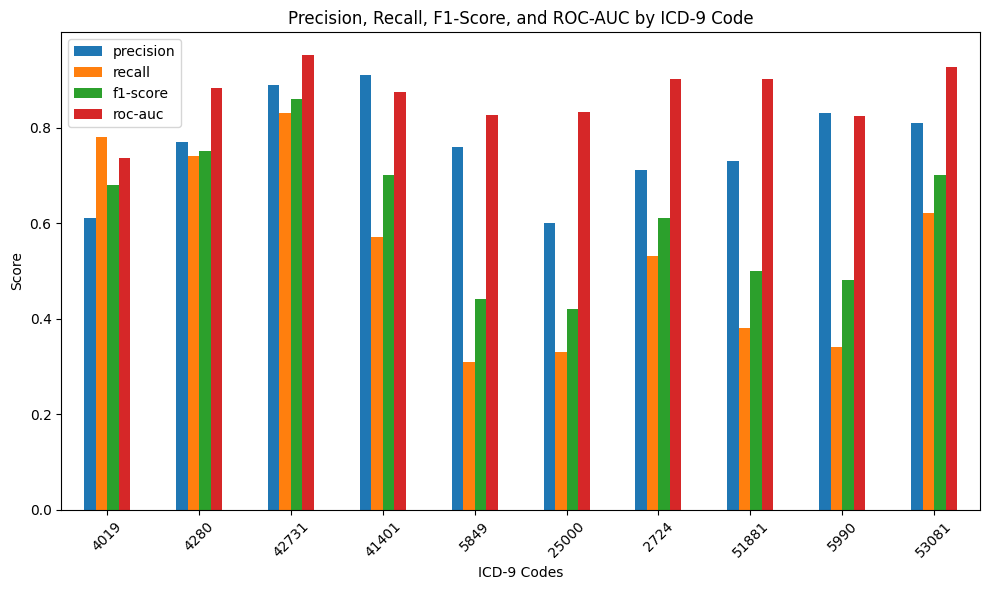

Test Accuracy: 0.84
Average Hamming Loss: 0.16
Classification Report:
              precision    recall  f1-score   support

        4019       0.61      0.78      0.68       236
        4280       0.77      0.74      0.75       186
       42731       0.89      0.83      0.86       160
       41401       0.91      0.57      0.70       168
        5849       0.76      0.31      0.44       110
       25000       0.60      0.33      0.42       103
        2724       0.71      0.53      0.61        98
       51881       0.73      0.38      0.50        99
        5990       0.83      0.34      0.48        89
       53081       0.81      0.62      0.70        81

   micro avg       0.74      0.59      0.66      1330
   macro avg       0.76      0.54      0.62      1330
weighted avg       0.76      0.59      0.64      1330
 samples avg       0.75      0.60      0.60      1330


ROC-AUC Scores by Label:
4019: 0.74
4280: 0.88
42731: 0.95
41401: 0.88
5849: 0.83
25000: 0.83
2724: 0.90
51881: 0.90

In [ ]:
from sklearn.metrics import hamming_loss, precision_score, classification_report, roc_auc_score
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def test(cnn_model, test_dataloader):
    cnn_model.eval()
    test_accuracy = []
    hamming_losses = []
    all_y_true = []
    all_y_pred = []
    all_y_probs = []  # To store predicted probabilities for AUC-ROC calculation

    num_labels = len(top_10_icd9)
    precisions_per_label = [[] for i in range(num_labels)]

    for x_tensor1, x_tensor2, y_true in test_dataloader:
        with torch.no_grad():
            y_pred = get_output(cnn_model, x_tensor1, x_tensor2)
            y_true = y_true.float()
        y_pred_binary = (y_pred > THRESHOLD).float()

        # Collect all predictions and true labels
        all_y_true.append(y_true.cpu())
        all_y_pred.append(y_pred_binary.cpu())
        all_y_probs.append(y_pred.cpu())  # Store predicted probabilities

        accuracy = calculate_accuracy(y_pred, y_true)
        test_accuracy.append(accuracy)

        # Calculate Hamming Loss
        hamming_loss_batch = hamming_loss(y_true.cpu(), y_pred_binary.cpu())
        hamming_losses.append(hamming_loss_batch)

        # Calculate precision scores per label
        precision_batch = precision_score(y_true.cpu(), y_pred_binary.cpu(), average=None, zero_division=1)
        for i, precision in enumerate(precision_batch):
            precisions_per_label[i].append(precision)

    # Concatenate all batches
    all_y_true = torch.cat(all_y_true, dim=0).numpy()
    all_y_pred = torch.cat(all_y_pred, dim=0).numpy()
    all_y_probs = torch.cat(all_y_probs, dim=0).numpy()  # Concatenate all predicted probabilities

    # Generate classification report
    class_report = classification_report(all_y_true, all_y_pred, target_names=list(top_10_icd9.keys()), zero_division=1)
    avg_test_accuracy = np.mean(test_accuracy)
    avg_hamming_loss = np.mean(hamming_losses)

    # Calculate average precision per label
    avg_precisions = [np.mean(precisions) for precisions in precisions_per_label]

    # Calculate ROC-AUC score per label using predicted probabilities
    roc_auc_per_label = roc_auc_score(all_y_true, all_y_probs, average=None)

    # Parse classification report
    class_names, metrics = parse_classification_report(class_report)

    # Add ROC-AUC to metrics
    metrics['roc-auc'] = roc_auc_per_label

    # Create DataFrame
    plot_df = pd.DataFrame(metrics, index=class_names)

    # Plotting
    plot_df.plot(kind='bar', figsize=(10, 6))
    plt.xlabel('ICD-9 Codes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, F1-Score, and ROC-AUC by ICD-9 Code')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(f"Test Accuracy: {avg_test_accuracy:.2f}")
    print(f"Average Hamming Loss: {avg_hamming_loss:.2f}")

    print("Classification Report:")
    print(class_report)

    # Display ROC-AUC scores
    print("\nROC-AUC Scores by Label:")
    for label, roc_auc in zip(top_10_icd9.keys(), roc_auc_per_label):
        print(f"{label}: {roc_auc:.2f}")

# Function to parse the classification report string and extract relevant metrics
def parse_classification_report(report_str):
    lines = report_str.split('\n')
    class_names = []
    metrics = {'precision': [], 'recall': [], 'f1-score': []}

    for line in lines[2:-5]:
        parts = line.split()
        if len(parts) > 0:
            class_names.append(parts[0])
            metrics['precision'].append(float(parts[1]))
            metrics['recall'].append(float(parts[2]))
            metrics['f1-score'].append(float(parts[3]))

    return class_names, metrics

# Load the best saved models
cnn_model.load_state_dict(torch.load('cnn_model.pth'))

# Test the models
test(cnn_model, test_dataloader)


cnn with attention

In [ ]:
import time
import random
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import classification_report, precision_score

def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed()

def initialize_model():
    num_labels = len(top_10_icd9)

    # Define CNN model
    cnn_model = StandaloneCNN_Attention()

    return cnn_model

def get_output(cnn_model, x_tensor1, x_tensor2):
    num_labels = len(top_10_icd9)
    # Get logits from CNN model
    cnn_logits = cnn_model(x_tensor1, x_tensor2)
    output_probability = torch.sigmoid(cnn_logits)

    return output_probability

def train(cnn_model, optimizer_cnn, train_dataloader, val_dataloader=None):
    patience = 10  # Initialize patience counter
    best_loss = float('inf')  # Initialize best validation loss
    epochs = 100
    loss_fn = nn.BCELoss()

    # Initialize empty lists to store true and predicted labels for both training and validation sets
    all_train_y_true = []
    all_train_y_pred = []

    for epoch_i in range(epochs):
        cnn_model.train()
        t0_epoch = time.time()
        total_loss = 0

        for step, (x_tensor1, x_tensor2, y_true) in enumerate(train_dataloader):
            y_pred = get_output(cnn_model, x_tensor1, x_tensor2)
            y_true = y_true.float()
            loss = loss_fn(y_pred, y_true)

            total_loss += loss.item()

            optimizer_cnn.zero_grad()
            loss.backward()
            optimizer_cnn.step()

            # Append true and predicted labels for the training set
            all_train_y_true.append(y_true.cpu().detach().numpy())
            all_train_y_pred.append((y_pred > 0.5).float().cpu().detach().numpy())

        avg_train_loss = total_loss / len(train_dataloader)

        if val_dataloader is not None:
            val_loss, avg_precision, avg_val_accuracy, _, _ = evaluate(cnn_model, val_dataloader, loss_fn)

            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | Average Train Loss : {avg_train_loss:.2f} | Val Loss: {val_loss:.2f} | Average Precision: {avg_precision:.2f} | Average Accuracy {avg_val_accuracy:.2f} |Time Elapsed: {time_elapsed:^9.2f}")

            if val_loss < best_loss:
                best_loss = val_loss
                patience = 10  # Reset patience counter
                torch.save(cnn_model.state_dict(), 'cnn_model2.pth')
            else:
                patience -= 1
                if patience == 0:
                    print("Stopped....")
                    break

    print("\nTraining complete!")

    # Generate and print the final classification report for the training set
    all_train_y_true = np.concatenate(all_train_y_true, axis=0)
    all_train_y_pred = np.concatenate(all_train_y_pred, axis=0)
    train_class_report = classification_report(all_train_y_true, all_train_y_pred, target_names=top_10_icd9.keys(), zero_division=1)
    print("Classification Report for Training Set:")
    print(train_class_report)

    return cnn_model

def evaluate(cnn_model, val_dataloader, loss_fn):
    cnn_model.eval()
    val_accuracy = []
    val_losses = []
    precisions = []
    all_y_true = []
    all_y_pred = []

    for x_tensor1, x_tensor2, y_true in val_dataloader:
        with torch.no_grad():
            y_pred = get_output(cnn_model, x_tensor1, x_tensor2)
            y_true = y_true.float()
            loss = loss_fn(y_pred, y_true)
            val_losses.append(loss.item())

            y_pred_binary = (y_pred > 0.5).float()
            precision_batch = precision_score(y_true.cpu(), y_pred_binary.cpu(), average='micro')
            precisions.append(precision_batch)

            accuracy = calculate_accuracy(y_pred, y_true)
            val_accuracy.append(accuracy)

            all_y_true.append(y_true.cpu())
            all_y_pred.append(y_pred_binary.cpu())

    all_y_true = torch.cat(all_y_true, dim=0).numpy()
    all_y_pred = torch.cat(all_y_pred, dim=0).numpy()
    avg_val_accuracy = np.mean(val_accuracy)
    avg_precision = sum(precisions) / len(precisions)
    avg_val_loss = np.mean(val_losses)

    return avg_val_loss, avg_precision, avg_val_accuracy, all_y_true, all_y_pred

def calculate_accuracy(y_pred, y_true):
    y_pred = (y_pred > 0.5).float()
    correct_predictions = (y_pred == y_true).float()
    instance_accuracy = torch.mean(correct_predictions, dim=1)
    average_accuracy = torch.mean(instance_accuracy).item()
    return average_accuracy

cnn_model = initialize_model()
optimizer_cnn = torch.optim.Adam(cnn_model.parameters(), lr=LR)
cnn_model = train(cnn_model, optimizer_cnn, train_dataloader, val_dataloader)


   1    | Average Train Loss : 0.52 | Val Loss: 0.45 | Average Precision: 0.63 | Average Accuracy 0.79 |Time Elapsed:   11.23  
   2    | Average Train Loss : 0.44 | Val Loss: 0.39 | Average Precision: 0.72 | Average Accuracy 0.82 |Time Elapsed:   11.42  
   3    | Average Train Loss : 0.39 | Val Loss: 0.38 | Average Precision: 0.69 | Average Accuracy 0.83 |Time Elapsed:   12.05  
   4    | Average Train Loss : 0.37 | Val Loss: 0.36 | Average Precision: 0.77 | Average Accuracy 0.84 |Time Elapsed:   11.99  
   5    | Average Train Loss : 0.34 | Val Loss: 0.37 | Average Precision: 0.72 | Average Accuracy 0.84 |Time Elapsed:   11.83  
   6    | Average Train Loss : 0.32 | Val Loss: 0.38 | Average Precision: 0.71 | Average Accuracy 0.84 |Time Elapsed:   13.62  
   7    | Average Train Loss : 0.30 | Val Loss: 0.39 | Average Precision: 0.73 | Average Accuracy 0.84 |Time Elapsed:   12.01  
   8    | Average Train Loss : 0.27 | Val Loss: 0.43 | Average Precision: 0.71 | Average Accuracy 0.83 |

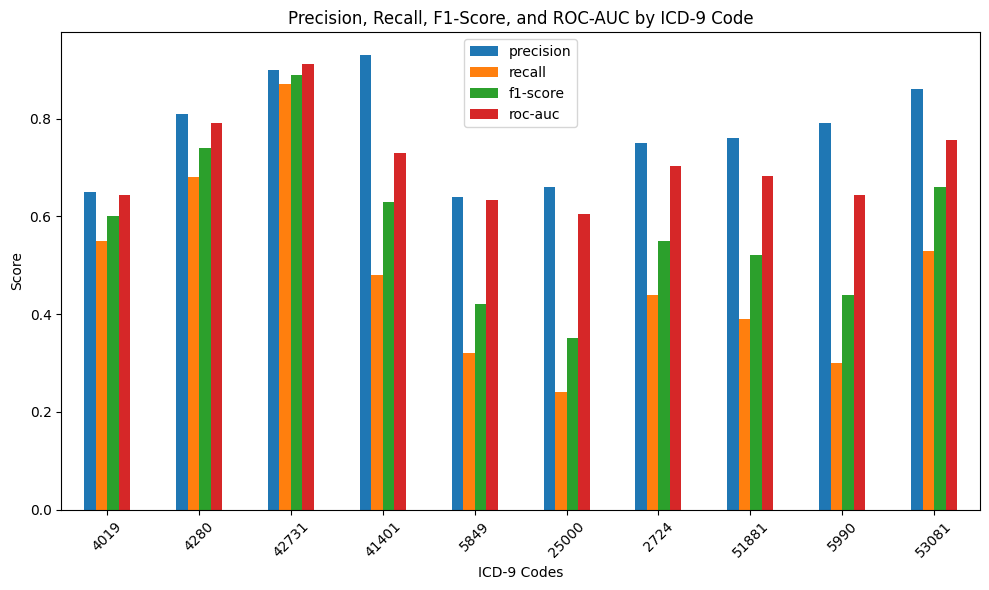

Test Accuracy: 0.83
Average Hamming Loss: 0.17
Classification Report:
              precision    recall  f1-score   support

        4019       0.65      0.55      0.60       236
        4280       0.81      0.68      0.74       186
       42731       0.90      0.87      0.89       160
       41401       0.93      0.48      0.63       168
        5849       0.64      0.32      0.42       110
       25000       0.66      0.24      0.35       103
        2724       0.75      0.44      0.55        98
       51881       0.76      0.39      0.52        99
        5990       0.79      0.30      0.44        89
       53081       0.86      0.53      0.66        81

   micro avg       0.78      0.52      0.62      1330
   macro avg       0.78      0.48      0.58      1330
weighted avg       0.78      0.52      0.61      1330
 samples avg       0.81      0.53      0.56      1330


ROC-AUC Scores by Label:
4019: 0.64
4280: 0.79
42731: 0.91
41401: 0.73
5849: 0.63
25000: 0.60
2724: 0.70
51881: 0.68

In [ ]:
from sklearn.metrics import hamming_loss, precision_score, classification_report, roc_auc_score
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def test(cnn_model, test_dataloader):
    cnn_model.eval()
    test_accuracy = []
    hamming_losses = []
    all_y_true = []
    all_y_pred = []

    num_labels = len(top_10_icd9)
    precisions_per_label = [[] for i in range(num_labels)]

    for x_tensor1, x_tensor2, y_true in test_dataloader:
        with torch.no_grad():
            y_pred = get_output(cnn_model, x_tensor1, x_tensor2)
            y_true = y_true.float()
        y_pred_binary = (y_pred > THRESHOLD).float()

        # Collect all predictions and true labels
        all_y_true.append(y_true.cpu())
        all_y_pred.append(y_pred_binary.cpu())

        accuracy = calculate_accuracy(y_pred, y_true)
        test_accuracy.append(accuracy)

        # Calculate Hamming Loss
        hamming_loss_batch = hamming_loss(y_true.cpu(), y_pred_binary.cpu())
        hamming_losses.append(hamming_loss_batch)

        # Calculate precision scores per label
        precision_batch = precision_score(y_true.cpu(), y_pred_binary.cpu(), average=None, zero_division=1)
        for i, precision in enumerate(precision_batch):
            precisions_per_label[i].append(precision)

    # Concatenate all batches
    all_y_true = torch.cat(all_y_true, dim=0).numpy()
    all_y_pred = torch.cat(all_y_pred, dim=0).numpy()

    # Generate classification report
    class_report = classification_report(all_y_true, all_y_pred, target_names=list(top_10_icd9.keys()), zero_division=1)
    avg_test_accuracy = np.mean(test_accuracy)
    avg_hamming_loss = np.mean(hamming_losses)

    # Calculate average precision per label
    avg_precisions = [np.mean(precisions) for precisions in precisions_per_label]

    # Calculate ROC-AUC score per label
    roc_auc_per_label = roc_auc_score(all_y_true, all_y_pred, average=None)

    # Parse classification report
    class_names, metrics = parse_classification_report(class_report)

    # Add ROC-AUC to metrics
    metrics['roc-auc'] = roc_auc_per_label

    # Create DataFrame
    plot_df = pd.DataFrame(metrics, index=class_names)

    # Plotting
    plot_df.plot(kind='bar', figsize=(10, 6))
    plt.xlabel('ICD-9 Codes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, F1-Score, and ROC-AUC by ICD-9 Code')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(f"Test Accuracy: {avg_test_accuracy:.2f}")
    print(f"Average Hamming Loss: {avg_hamming_loss:.2f}")

    print("Classification Report:")
    print(class_report)

    # Display ROC-AUC scores
    print("\nROC-AUC Scores by Label:")
    for label, roc_auc in zip(top_10_icd9.keys(), roc_auc_per_label):
        print(f"{label}: {roc_auc:.2f}")

# Function to parse the classification report string and extract relevant metrics
def parse_classification_report(report_str):
    lines = report_str.split('\n')
    class_names = []
    metrics = {'precision': [], 'recall': [], 'f1-score': []}

    for line in lines[2:-5]:
        parts = line.split()
        if len(parts) > 0:
            class_names.append(parts[0])
            metrics['precision'].append(float(parts[1]))
            metrics['recall'].append(float(parts[2]))
            metrics['f1-score'].append(float(parts[3]))

    return class_names, metrics

# Load the best saved models
cnn_model.load_state_dict(torch.load('cnn_model2.pth'))

# Test the models
test(cnn_model, test_dataloader)


# BI-LSTM

In [ ]:
LR = 0.002

In [ ]:
import time
import random
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import classification_report, precision_score

def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed()

def initialize_model(X_train_tensor, embedding_tensor_train):
    num_labels = len(top_10_icd9)

    # Hyperparameters for Bi-LSTM
    num_layers = 2
    hidden_size = 128

    # Define BiLSTM model
    bi_lstm_model = StandaloneBiLSTM(hidden_size, num_layers, num_labels)
    return bi_lstm_model

def get_output(bi_lstm_model, x_tensor1, x_tensor2):
    num_labels = len(top_10_icd9)
    # Get logits from BiLSTM model
    bi_lstm_logits = bi_lstm_model(x_tensor1)

    output_probability = torch.sigmoid(bi_lstm_logits)

    return output_probability

def train(bi_lstm_model, optimizer_bilstm, train_dataloader, val_dataloader):
    patience = 10  # Initialize patience counter
    best_loss = float('inf')  # Initialize best validation loss
    epochs = 100
    loss_fn = nn.BCELoss()

    # Initialize empty lists to store true and predicted labels for both training and validation sets
    all_train_y_true = []
    all_train_y_pred = []

    for epoch_i in range(epochs):
        bi_lstm_model.train()
        t0_epoch = time.time()
        total_loss = 0

        for step, (x_tensor1, x_tensor2, y_true) in enumerate(train_dataloader):
            y_pred = get_output(bi_lstm_model, x_tensor1, x_tensor2)
            y_true = y_true.float()
            loss = loss_fn(y_pred, y_true)

            total_loss += loss.item()

            optimizer_bilstm.zero_grad()
            loss.backward()
            optimizer_bilstm.step()

            # Append true and predicted labels for the training set
            all_train_y_true.append(y_true.cpu().detach().numpy())
            all_train_y_pred.append((y_pred > THRESHOLD).float().cpu().detach().numpy())

        avg_train_loss = total_loss / len(train_dataloader)

        if val_dataloader is not None:
            val_loss, avg_precision, avg_val_accuracy, _, _ = evaluate(bi_lstm_model, val_dataloader, loss_fn)

            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | Average Train Loss : {avg_train_loss:.2f} | Val Loss: {val_loss:.2f} | Average Precision: {avg_precision:.2f} | Average Accuracy {avg_val_accuracy:.2f} |Time Elapsed: {time_elapsed:^9.2f}")

            if val_loss < best_loss:
                best_loss = val_loss
                patience = 10  # Reset patience counter
                torch.save(bi_lstm_model.state_dict(), 'bi_lstm_model.pth')
            else:
                patience -= 1
                if patience == 0:
                    print("Stopped....")
                    break

    print("\nTraining complete!")
    # Generate and print the final classification report for the training set
    all_train_y_true = np.concatenate(all_train_y_true, axis=0)
    all_train_y_pred = np.concatenate(all_train_y_pred, axis=0)
    train_class_report = classification_report(all_train_y_true, all_train_y_pred, target_names=top_10_icd9.keys(), zero_division=1)
    print("Classification Report for Training Set:")
    print(train_class_report)

    return bi_lstm_model

def evaluate(bi_lstm_model, val_dataloader, loss_fn):
    bi_lstm_model.eval()
    val_accuracy = []
    val_losses = []
    precisions = []
    all_y_true = []
    all_y_pred = []

    for x_tensor1, x_tensor2, y_true in val_dataloader:
        with torch.no_grad():
            y_pred = get_output(bi_lstm_model, x_tensor1, x_tensor2)
            y_true = y_true.float()
            loss = loss_fn(y_pred, y_true)
            val_losses.append(loss.item())

            y_pred_binary = (y_pred > THRESHOLD).float()
            precision_batch = precision_score(y_true.cpu(), y_pred_binary.cpu(), average='micro')
            precisions.append(precision_batch)

            accuracy = calculate_accuracy(y_pred, y_true)
            val_accuracy.append(accuracy)

            all_y_true.append(y_true.cpu())
            all_y_pred.append(y_pred_binary.cpu())

    all_y_true = torch.cat(all_y_true, dim=0).numpy()
    all_y_pred = torch.cat(all_y_pred, dim=0).numpy()
    avg_val_accuracy = np.mean(val_accuracy)
    avg_precision = sum(precisions) / len(precisions)
    avg_val_loss = np.mean(val_losses)

    return avg_val_loss, avg_precision, avg_val_accuracy, all_y_true, all_y_pred

def calculate_accuracy(y_pred, y_true):
    y_pred = (y_pred > THRESHOLD).float()
    correct_predictions = (y_pred == y_true).float()
    instance_accuracy = torch.mean(correct_predictions, dim=1)
    average_accuracy = torch.mean(instance_accuracy).item()
    return average_accuracy

bi_lstm_model = initialize_model(X_train_tensor, embedding_tensor_train)
optimizer_bilstm = torch.optim.Adam(bi_lstm_model.parameters(), lr=LR)
lstm_model = train(bi_lstm_model, optimizer_bilstm, train_dataloader, val_dataloader)


   1    | Average Train Loss : 0.54 | Val Loss: 0.51 | Average Precision: 0.54 | Average Accuracy 0.76 |Time Elapsed:  137.24  
   2    | Average Train Loss : 0.51 | Val Loss: 0.49 | Average Precision: 0.57 | Average Accuracy 0.77 |Time Elapsed:  129.47  
   3    | Average Train Loss : 0.48 | Val Loss: 0.47 | Average Precision: 0.62 | Average Accuracy 0.79 |Time Elapsed:  124.60  
   4    | Average Train Loss : 0.46 | Val Loss: 0.45 | Average Precision: 0.68 | Average Accuracy 0.80 |Time Elapsed:  130.10  
   5    | Average Train Loss : 0.44 | Val Loss: 0.43 | Average Precision: 0.72 | Average Accuracy 0.81 |Time Elapsed:  133.48  
   6    | Average Train Loss : 0.44 | Val Loss: 0.44 | Average Precision: 0.70 | Average Accuracy 0.81 |Time Elapsed:  130.27  
   7    | Average Train Loss : 0.44 | Val Loss: 0.42 | Average Precision: 0.73 | Average Accuracy 0.82 |Time Elapsed:  136.35  
   8    | Average Train Loss : 0.42 | Val Loss: 0.42 | Average Precision: 0.73 | Average Accuracy 0.82 |

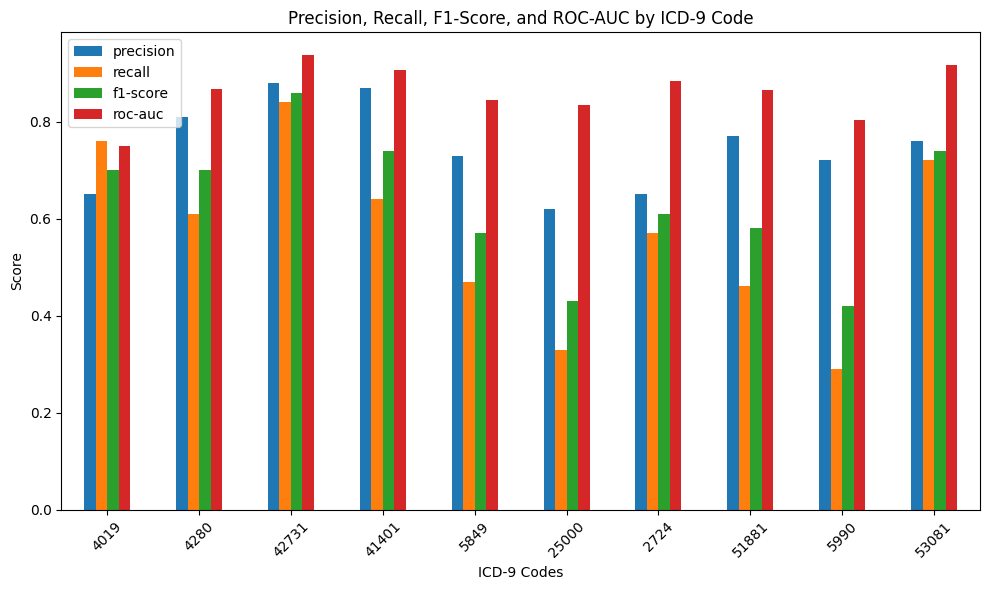

Test Accuracy: 0.84
Average Hamming Loss: 0.16
Classification Report:
              precision    recall  f1-score   support

        4019       0.65      0.76      0.70       236
        4280       0.81      0.61      0.70       186
       42731       0.88      0.84      0.86       160
       41401       0.87      0.64      0.74       168
        5849       0.73      0.47      0.57       110
       25000       0.62      0.33      0.43       103
        2724       0.65      0.57      0.61        98
       51881       0.77      0.46      0.58        99
        5990       0.72      0.29      0.42        89
       53081       0.76      0.72      0.74        81

   micro avg       0.75      0.61      0.67      1330
   macro avg       0.75      0.57      0.63      1330
weighted avg       0.75      0.61      0.66      1330
 samples avg       0.76      0.63      0.63      1330


ROC-AUC Scores by Label:
4019: 0.75
4280: 0.87
42731: 0.94
41401: 0.91
5849: 0.84
25000: 0.83
2724: 0.88
51881: 0.87

In [ ]:
from sklearn.metrics import hamming_loss, precision_score, classification_report, roc_auc_score
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

THRESHOLD = 0.5

def test(bi_lstm_model, test_dataloader):
    bi_lstm_model.eval()
    test_accuracy = []
    hamming_losses = []
    all_y_true = []
    all_y_pred = []
    all_y_scores = []

    num_labels = len(top_10_icd9)
    precisions_per_label = [[] for _ in range(num_labels)]

    for x_tensor1, x_tensor2, y_true in test_dataloader:
        with torch.no_grad():
            y_pred = get_output(bi_lstm_model, x_tensor1, x_tensor2)
            y_true = y_true.float()
        y_pred_binary = (y_pred > THRESHOLD).float()

        # Collect all predictions, true labels, and scores
        all_y_true.append(y_true.cpu())
        all_y_pred.append(y_pred_binary.cpu())
        all_y_scores.append(y_pred.cpu())

        accuracy = calculate_accuracy(y_pred, y_true)
        test_accuracy.append(accuracy)

        # Calculate Hamming Loss
        hamming_loss_batch = hamming_loss(y_true.cpu(), y_pred_binary.cpu())
        hamming_losses.append(hamming_loss_batch)

        # Calculate precision scores per label
        precision_batch = precision_score(y_true.cpu(), y_pred_binary.cpu(), average=None, zero_division=1)
        for i, precision in enumerate(precision_batch):
            precisions_per_label[i].append(precision)

    # Concatenate all batches
    all_y_true = torch.cat(all_y_true, dim=0).numpy()
    all_y_pred = torch.cat(all_y_pred, dim=0).numpy()
    all_y_scores = torch.cat(all_y_scores, dim=0).numpy()

    # Generate classification report
    class_report = classification_report(all_y_true, all_y_pred, target_names=list(top_10_icd9.keys()), zero_division=1)
    avg_test_accuracy = np.mean(test_accuracy)
    avg_hamming_loss = np.mean(hamming_losses)

    # Calculate average precision per label
    avg_precisions = [np.mean(precisions) for precisions in precisions_per_label]

    # Calculate ROC-AUC score per label
    roc_auc_per_label = roc_auc_score(all_y_true, all_y_scores, average=None)

    # Parse classification report
    class_names, metrics = parse_classification_report(class_report)

    # Add ROC-AUC to metrics
    metrics['roc-auc'] = roc_auc_per_label

    # Create DataFrame
    plot_df = pd.DataFrame(metrics, index=class_names)

    # Plotting
    plot_df.plot(kind='bar', figsize=(10, 6))
    plt.xlabel('ICD-9 Codes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, F1-Score, and ROC-AUC by ICD-9 Code')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(f"Test Accuracy: {avg_test_accuracy:.2f}")
    print(f"Average Hamming Loss: {avg_hamming_loss:.2f}")

    print("Classification Report:")
    print(class_report)

    # Display ROC-AUC scores
    print("\nROC-AUC Scores by Label:")
    for label, roc_auc in zip(top_10_icd9.keys(), roc_auc_per_label):
        print(f"{label}: {roc_auc:.2f}")

# Function to parse the classification report string and extract relevant metrics
def parse_classification_report(report_str):
    lines = report_str.split('\n')
    class_names = []
    metrics = {'precision': [], 'recall': [], 'f1-score': []}

    for line in lines[2:-5]:
        parts = line.split()
        if len(parts) > 0:
            class_names.append(parts[0])
            metrics['precision'].append(float(parts[1]))
            metrics['recall'].append(float(parts[2]))
            metrics['f1-score'].append(float(parts[3]))

    return class_names, metrics

# Load the best saved models
bi_lstm_model.load_state_dict(torch.load('bi_lstm_model.pth'))

# Test the models
test(bi_lstm_model, test_dataloader)


# bi-lstm with attention

In [ ]:
import time
import random
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import classification_report, precision_score

def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed()

def initialize_model(X_train_tensor, embedding_tensor_train):
    num_labels = len(top_10_icd9)

    # Hyperparameters for Bi-LSTM
    num_layers = 2
    hidden_size = 128

    # Define BiLSTM model
    bi_lstm_model = StandaloneBiLSTM_Attention(hidden_size, num_layers, num_labels)
    return bi_lstm_model

def get_output(bi_lstm_model, x_tensor1, x_tensor2):
    num_labels = len(top_10_icd9)
    # Get logits from CNN and BiLSTM models
    bi_lstm_logits = bi_lstm_model(x_tensor1)

    output_probability = torch.sigmoid(bi_lstm_logits)

    return output_probability

def train(bi_lstm_model, optimizer_bilstm, train_dataloader, val_dataloader):
    patience = 10  # Initialize patience counter
    best_loss = float('inf')  # Initialize best validation loss
    epochs = 100
    loss_fn = nn.BCELoss()

    # Initialize empty lists to store true and predicted labels for both training and validation sets
    all_train_y_true = []
    all_train_y_pred = []

    for epoch_i in range(epochs):
        bi_lstm_model.train()
        t0_epoch = time.time()
        total_loss = 0

        for step, (x_tensor1, x_tensor2, y_true) in enumerate(train_dataloader):
            y_pred = get_output(bi_lstm_model, x_tensor1, x_tensor2)

            y_true = y_true.float()
            loss = loss_fn(y_pred, y_true)

            total_loss += loss.item()

            optimizer_bilstm.zero_grad()
            loss.backward()
            optimizer_bilstm.step()

            # Append true and predicted labels for the training set
            all_train_y_true.append(y_true.cpu().detach().numpy())
            all_train_y_pred.append((y_pred > THRESHOLD).float().cpu().detach().numpy())

        avg_train_loss = total_loss / len(train_dataloader)

        if val_dataloader is not None:
            val_loss, avg_precision, avg_val_accuracy, _, _ = evaluate(bi_lstm_model, val_dataloader, loss_fn)

            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | Average Train Loss : {avg_train_loss:.2f} | Val Loss: {val_loss:.2f} | Average Precision: {avg_precision:.2f} | Average Accuracy {avg_val_accuracy:.2f} |Time Elapsed: {time_elapsed:^9.2f}")

            if val_loss < best_loss:
                best_loss = val_loss
                patience = 10  # Reset patience counter
                torch.save(bi_lstm_model.state_dict(), 'bi_lstm_model4.pth')
            else:
                patience -= 1
                if patience == 0:
                    print("Stopped....")
                    break

    print("\nTraining complete!")
    # Generate and print the final classification report for the training set
    all_train_y_true = np.concatenate(all_train_y_true, axis=0)
    all_train_y_pred = np.concatenate(all_train_y_pred, axis=0)
    train_class_report = classification_report(all_train_y_true, all_train_y_pred, target_names=top_10_icd9.keys(), zero_division=1)
    print("Classification Report for Training Set:")
    print(train_class_report)

    return bi_lstm_model

def evaluate(bi_lstm_model, val_dataloader, loss_fn):
    bi_lstm_model.eval()
    val_accuracy = []
    val_losses = []
    precisions = []
    all_y_true = []
    all_y_pred = []

    for x_tensor1, x_tensor2, y_true in val_dataloader:
        with torch.no_grad():
            y_pred = get_output(bi_lstm_model, x_tensor1, x_tensor2)
            y_true = y_true.float()
            loss = loss_fn(y_pred, y_true)
            val_losses.append(loss.item())

            y_pred_binary = (y_pred > THRESHOLD).float()
            precision_batch = precision_score(y_true.cpu(), y_pred_binary.cpu(), average='micro')
            precisions.append(precision_batch)

            accuracy = calculate_accuracy(y_pred, y_true)
            val_accuracy.append(accuracy)

            all_y_true.append(y_true.cpu())
            all_y_pred.append(y_pred_binary.cpu())

    all_y_true = torch.cat(all_y_true, dim=0).numpy()
    all_y_pred = torch.cat(all_y_pred, dim=0).numpy()
    avg_val_accuracy = np.mean(val_accuracy)
    avg_precision = sum(precisions) / len(precisions)
    avg_val_loss = np.mean(val_losses)

    # class_report = classification_report(all_y_true, all_y_pred, target_names=[f'Label {i}' for i in top_10_icd9])
    # print("Classification Report for Validation Set:")
    # print(class_report)

    return avg_val_loss, avg_precision, avg_val_accuracy, all_y_true, all_y_pred

def calculate_accuracy(y_pred, y_true):
    y_pred = (y_pred > THRESHOLD).float()
    correct_predictions = (y_pred == y_true).float()
    instance_accuracy = torch.mean(correct_predictions, dim=1)
    average_accuracy = torch.mean(instance_accuracy).item()
    return average_accuracy

bi_lstm_model = initialize_model(X_train_tensor, embedding_tensor_train)
optimizer_bilstm = torch.optim.Adam(bi_lstm_model.parameters(), lr=LR)
lstm_model = train(bi_lstm_model, optimizer_bilstm, train_dataloader, val_dataloader)


   1    | Average Train Loss : 0.54 | Val Loss: 0.49 | Average Precision: 0.61 | Average Accuracy 0.77 |Time Elapsed:  137.64  
   2    | Average Train Loss : 0.48 | Val Loss: 0.44 | Average Precision: 0.69 | Average Accuracy 0.80 |Time Elapsed:  140.36  
   3    | Average Train Loss : 0.45 | Val Loss: 0.43 | Average Precision: 0.72 | Average Accuracy 0.81 |Time Elapsed:  141.57  
   4    | Average Train Loss : 0.43 | Val Loss: 0.43 | Average Precision: 0.70 | Average Accuracy 0.81 |Time Elapsed:  139.18  
   5    | Average Train Loss : 0.41 | Val Loss: 0.40 | Average Precision: 0.73 | Average Accuracy 0.83 |Time Elapsed:  129.92  
   6    | Average Train Loss : 0.39 | Val Loss: 0.40 | Average Precision: 0.72 | Average Accuracy 0.83 |Time Elapsed:  128.59  
   7    | Average Train Loss : 0.37 | Val Loss: 0.38 | Average Precision: 0.74 | Average Accuracy 0.83 |Time Elapsed:  129.31  
   8    | Average Train Loss : 0.35 | Val Loss: 0.37 | Average Precision: 0.76 | Average Accuracy 0.84 |

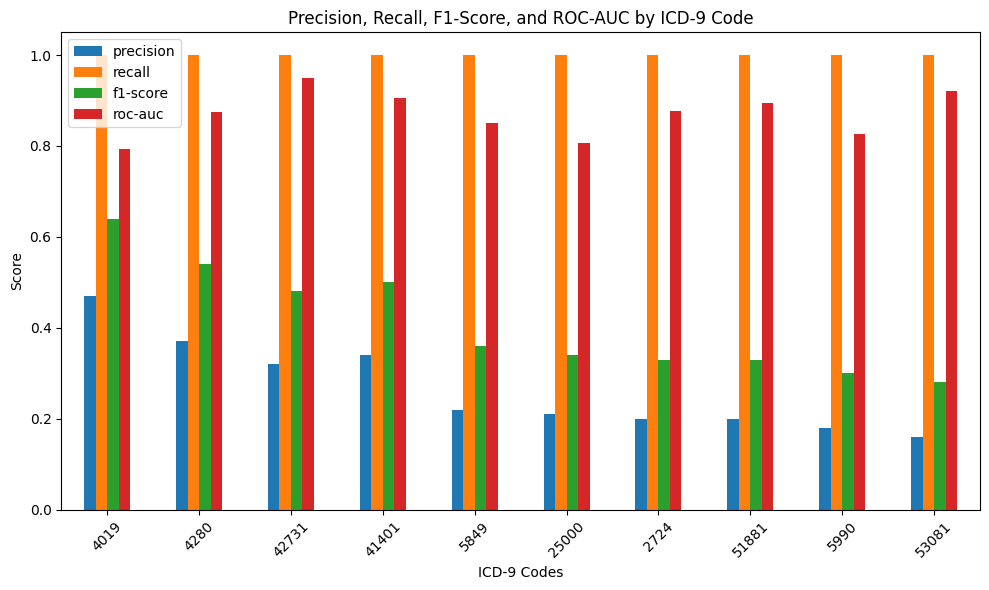

Test Accuracy: 0.84
Average Hamming Loss: 0.73
Classification Report:
              precision    recall  f1-score   support

        4019       0.47      1.00      0.64       236
        4280       0.37      1.00      0.54       186
       42731       0.32      1.00      0.48       160
       41401       0.34      1.00      0.50       168
        5849       0.22      1.00      0.36       110
       25000       0.21      1.00      0.34       103
        2724       0.20      1.00      0.33        98
       51881       0.20      1.00      0.33        99
        5990       0.18      1.00      0.30        89
       53081       0.16      1.00      0.28        81

   micro avg       0.27      1.00      0.42      1330
   macro avg       0.27      1.00      0.41      1330
weighted avg       0.30      1.00      0.45      1330
 samples avg       0.27      1.00      0.40      1330


ROC-AUC Scores by Label:
4019: 0.79
4280: 0.87
42731: 0.95
41401: 0.91
5849: 0.85
25000: 0.81
2724: 0.88
51881: 0.90

In [ ]:
from sklearn.metrics import hamming_loss, precision_score, classification_report, roc_auc_score
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

THRESHOLD = 0.5

def test(bi_lstm_model, test_dataloader):
    bi_lstm_model.eval()
    test_accuracy = []
    hamming_losses = []
    all_y_true = []
    all_y_pred = []
    all_y_probs = []

    num_labels = len(top_10_icd9)
    precisions_per_label = [[] for i in range(num_labels)]

    for x_tensor1, x_tensor2, y_true in test_dataloader:
        with torch.no_grad():
            y_pred = get_output(bi_lstm_model, x_tensor1, x_tensor2)
            y_true = y_true.float()
            y_probs = torch.sigmoid(y_pred)  # Convert logits to probabilities
        y_pred_binary = (y_probs > THRESHOLD).float()

        # Collect all predictions, true labels, and probabilities
        all_y_true.append(y_true.cpu())
        all_y_pred.append(y_pred_binary.cpu())
        all_y_probs.append(y_probs.cpu())

        accuracy = calculate_accuracy(y_pred, y_true)
        test_accuracy.append(accuracy)

        # Calculate Hamming Loss
        hamming_loss_batch = hamming_loss(y_true.cpu(), y_pred_binary.cpu())
        hamming_losses.append(hamming_loss_batch)

        # Calculate precision scores per label
        precision_batch = precision_score(y_true.cpu(), y_pred_binary.cpu(), average=None)
        for i, precision in enumerate(precision_batch):
            precisions_per_label[i].append(precision)

    # Concatenate all batches
    all_y_true = torch.cat(all_y_true, dim=0).numpy()
    all_y_pred = torch.cat(all_y_pred, dim=0).numpy()
    all_y_probs = torch.cat(all_y_probs, dim=0).numpy()

    # Generate classification report
    class_report = classification_report(all_y_true, all_y_pred, target_names=list(top_10_icd9.keys()), zero_division=0)
    avg_test_accuracy = np.mean(test_accuracy)
    avg_hamming_loss = np.mean(hamming_losses)

    # Calculate average precision per label
    avg_precisions = [np.mean(precisions) for precisions in precisions_per_label]

    # Calculate ROC-AUC score per label
    roc_auc_per_label = roc_auc_score(all_y_true, all_y_probs, average=None)

    # Parse classification report
    class_names, metrics = parse_classification_report(class_report)

    # Add ROC-AUC to metrics
    metrics['roc-auc'] = roc_auc_per_label

    # Create DataFrame
    plot_df = pd.DataFrame(metrics, index=class_names)

    # Plotting
    plot_df.plot(kind='bar', figsize=(10, 6))
    plt.xlabel('ICD-9 Codes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, F1-Score, and ROC-AUC by ICD-9 Code')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(f"Test Accuracy: {avg_test_accuracy:.2f}")
    print(f"Average Hamming Loss: {avg_hamming_loss:.2f}")

    print("Classification Report:")
    print(class_report)

    # Display ROC-AUC scores
    print("\nROC-AUC Scores by Label:")
    for label, roc_auc in zip(top_10_icd9.keys(), roc_auc_per_label):
        print(f"{label}: {roc_auc:.2f}")

# Function to parse the classification report string and extract relevant metrics
def parse_classification_report(report_str):
    lines = report_str.split('\n')
    class_names = []
    metrics = {'precision': [], 'recall': [], 'f1-score': []}

    for line in lines[2:-5]:
        parts = line.split()
        if len(parts) > 0:
            class_names.append(parts[0])
            metrics['precision'].append(float(parts[1]))
            metrics['recall'].append(float(parts[2]))
            metrics['f1-score'].append(float(parts[3]))

    return class_names, metrics

# Load the best saved models
bi_lstm_model.load_state_dict(torch.load('bi_lstm_model4.pth'))

# Test the models
test(bi_lstm_model, test_dataloader)
